In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau


from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121


from itertools import chain

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [2]:
BATCH_SIZE = 48

image_height = 299
image_width = 299

In [3]:
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            brightness_range = [0.95,1.05],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=False,
                            vertical_flip=False,
                            fill_mode='nearest'                                   
                        )
print('Data Augmentation 2 was created')

data_generator_3 = ImageDataGenerator (rescale=1./255)


Data Augmentation 1 was created
Data Augmentation 2 was created


In [4]:
train_generator1 = data_generator_1.flow_from_directory(
    directory = r"D:\Prayag Files\TIET\Extras\hackathons\analog\Research Papers\Mine\Training", 
    color_mode = "rgb",
    target_size = (image_height, image_width),
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

print('Data Augmentation 1 was used to generate train data set\n')

Found 2870 images belonging to 4 classes.
Data Augmentation 1 was used to generate train data set



In [5]:
test_generator = data_generator_3.flow_from_directory(
    directory = r"D:\Prayag Files\TIET\Extras\hackathons\analog\Research Papers\Mine\Testing", 
    color_mode = "rgb",
    target_size = (image_height, image_width), 
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 42)

Found 394 images belonging to 4 classes.


In [6]:
dict_class = train_generator1.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())  
print('Class labels: {}'.format(class_names))

Dictionary: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Class labels: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


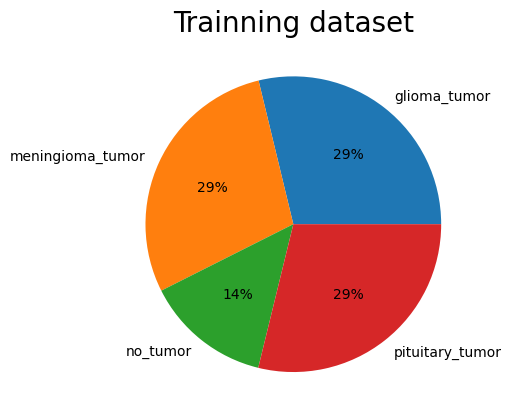

In [7]:
frequency = np.unique(train_generator1.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='20')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');

In [8]:
print("Dataset Characteristics of Train Data Set:\n")
print("Number of images:", len(train_generator1.classes))
print("Number of glioma_tumor images:", len([label for label in train_generator1.classes if label == 0]))
print("Number of meningioma_tumor images:", len([label for label in train_generator1.classes if label == 1]))
print("Number of no_tumor images:", len([label for label in train_generator1.classes if label == 2]))
print("Number of pituitary_tumor images:", len([label for label in train_generator1.classes if label == 3]))
print()


print("Dataset Characteristics of Test Data Set:\n")
print("Number of images:", len(test_generator.classes))
print("Number of glioma_tumor images:", len([label for label in test_generator.classes if label == 0]))
print("Number of meningioma_tumor images:", len([label for label in test_generator.classes if label == 1]))
print("Number of no_tumor images:", len([label for label in test_generator.classes if label == 2]))
print("Number of pituitary_tumor images:", len([label for label in test_generator.classes if label == 3]))
print()

Dataset Characteristics of Train Data Set:

Number of images: 2870
Number of glioma_tumor images: 826
Number of meningioma_tumor images: 822
Number of no_tumor images: 395
Number of pituitary_tumor images: 827

Dataset Characteristics of Test Data Set:

Number of images: 394
Number of glioma_tumor images: 100
Number of meningioma_tumor images: 115
Number of no_tumor images: 105
Number of pituitary_tumor images: 74



In [9]:
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator1.classes), y= train_generator1.classes)
class_weights = dict(zip(np.unique(train_generator1.classes), class_weights))
class_weights

{0: 0.8686440677966102,
 1: 0.8728710462287105,
 2: 1.8164556962025316,
 3: 0.8675937122128174}

Train image data from Data Augmentation 1


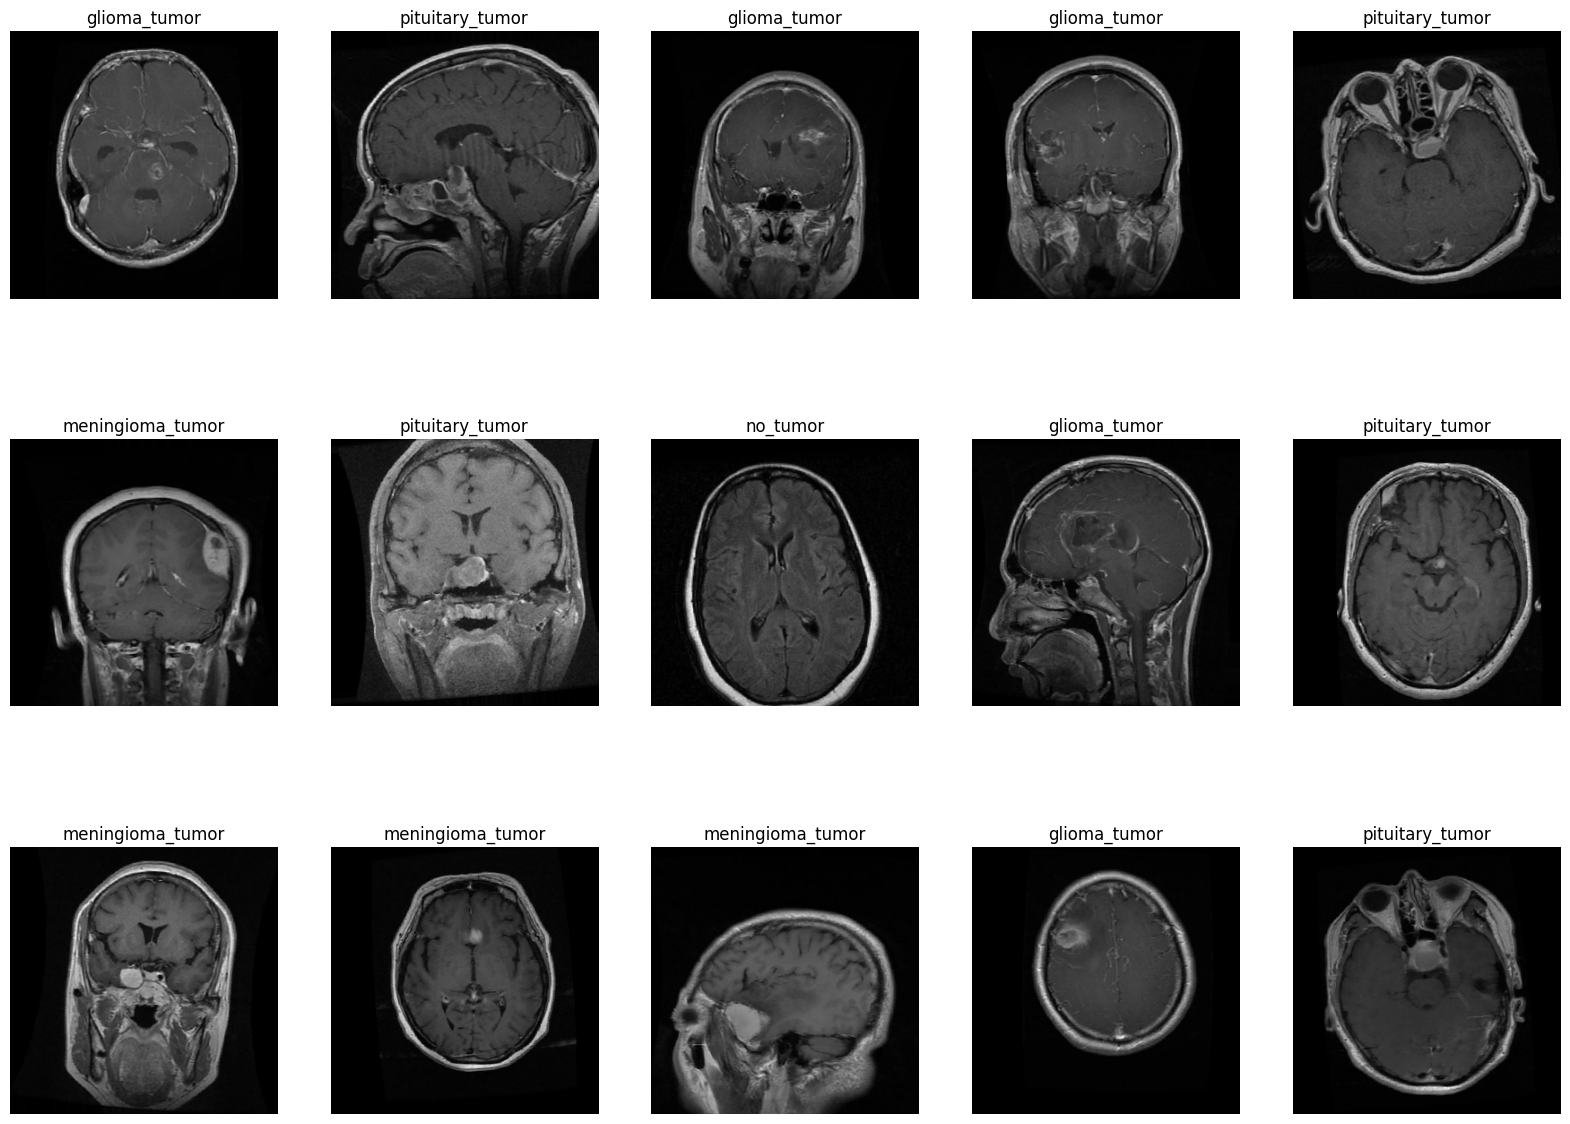

In [10]:
print('Train image data from Data Augmentation 1')
img, label = next(train_generator1)


plt.figure(figsize=[20, 15])
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

In [11]:

EPOCHS = 2


num_gpus = 2




early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)


reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)


train_data = train_generator1

In [12]:

strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])


with strategy.scope():
    

    base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))


    for layer in base_model_VGG16.layers:
        layer.trainable = False
   
    model_VGG16 = Sequential()
    model_VGG16.add(base_model_VGG16)


    model_VGG16.add(GlobalAveragePooling2D())
    model_VGG16.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.4))
    model_VGG16.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model_VGG16.add(Dropout(0.2))
    model_VGG16.add(Dense(4, activation='softmax'))


    print("Model Summary (VGG16):")
    model_VGG16.summary()
    print()


    model_VGG16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history_VGG16 = model_VGG16.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    val_loss_VGG16, val_accuracy_VGG16 = model_VGG16.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_VGG16:.4f}')
    print(f'Validation Accuracy: {val_accuracy_VGG16:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (VGG16):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)


Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 2860s 48s/step - accuracy: 0.2669 - loss: 1.7303 - val_accuracy: 0.3096 - val_loss: 1.5515
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 902s 15s/step - accuracy: 0.4287 - loss: 1.3879 - val_accuracy: 0.4061 - val_loss: 1.3863
Restoring model weights from the end of the best epoch: 2.
9/9 ━━━━━━━━━━━━━━━━━━━━ 115s 13s/step - accuracy: 0.3824 - loss: 1.4087
Validation Loss: 1.4015
Validation Accuracy: 0.4010


In [13]:
%%time

strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])


with strategy.scope():
    
   
    base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))


    for layer in base_model_MobileNet.layers:
        layer.trainable = False
    
   
    model_MobileNet = Sequential()
    model_MobileNet.add(base_model_MobileNet)

   
    model_MobileNet.add(GlobalAveragePooling2D())
    model_MobileNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_MobileNet.add(Dropout(0.4))
    model_MobileNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_MobileNet.add(Dropout(0.2))
    model_MobileNet.add(Dense(4, activation='softmax'))


    print("Model Summary (MobileNetV2):")
    model_MobileNet.summary()
    print()

 
    model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history_MobileNet = model_MobileNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)


    val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_MobileNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (MobileNetV2):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)


Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.4482 - loss: 1.5041 - val_accuracy: 0.3909 - val_loss: 1.8505
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.6730 - loss: 1.0206 - val_accuracy: 0.5127 - val_loss: 1.7252
Restoring model weights from the end of the best epoch: 2.
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4911 - loss: 1.7359
Validation Loss: 1.7551
Validation Accuracy: 0.4924
CPU times: total: 14min 39s
Wall time: 8min 10s


In [14]:
%%time


strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])


with strategy.scope():
    
  
    base_model_DenseNet = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))


    for layer in base_model_DenseNet.layers:
        layer.trainable = False  
    

    model_DenseNet = Sequential()
    model_DenseNet.add(base_model_DenseNet)

 
    model_DenseNet.add(GlobalAveragePooling2D())
    model_DenseNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_DenseNet.add(Dropout(0.4))
    model_DenseNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_DenseNet.add(Dropout(0.2))    
    model_DenseNet.add(Dense(4, activation='softmax'))


    print("Model Summary (DenseNet121):")
    model_DenseNet.summary()
    print()


    model_DenseNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history_DenseNet = model_DenseNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)


    val_loss_DenseNet, val_accuracy_DenseNet = model_DenseNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_DenseNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_DenseNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


Model Summary (DenseNet121):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)


Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 507s 6s/step - accuracy: 0.3434 - loss: 1.7210 - val_accuracy: 0.4670 - val_loss: 1.4815
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 366s 6s/step - accuracy: 0.6296 - loss: 1.0896 - val_accuracy: 0.4010 - val_loss: 1.7337
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
9/9 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4537 - loss: 1.4953
Validation Loss: 1.3959
Validation Accuracy: 0.4670
CPU times: total: 56min 13s
Wall time: 15min 19s


In [15]:
%%time


strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])


with strategy.scope():
    

    base_model_Inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))


    for layer in base_model_Inception.layers:
        layer.trainable = False  
        

    model_Inception = Sequential()
    model_Inception.add(base_model_Inception)

 
    model_Inception.add(GlobalAveragePooling2D())
    model_Inception.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_Inception.add(Dropout(0.4))
    model_Inception.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_Inception.add(Dropout(0.2))
        
    model_Inception.add(Dense(4, activation='softmax'))


    print("Model Summary (InceptionV3):")
    model_Inception.summary()
    print()


    model_Inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

 
    history_Inception = model_Inception.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)


    val_loss_Inception, val_accuracy_Inception = model_Inception.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_Inception:.4f}')
    print(f'Validation Accuracy: {val_accuracy_Inception:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (InceptionV3):


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)


Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 276s 4s/step - accuracy: 0.4192 - loss: 1.6135 - val_accuracy: 0.4264 - val_loss: 1.6137
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.6587 - loss: 1.0659 - val_accuracy: 0.5279 - val_loss: 1.5327
Restoring model weights from the end of the best epoch: 2.
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5256 - loss: 1.4886
Validation Loss: 1.4233
Validation Accuracy: 0.5381
CPU times: total: 43min 26s
Wall time: 9min 21s


In [16]:
%%time

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import regularizers

strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])


with strategy.scope():
    

    base_model_ResNet = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

   
    for layer in base_model_ResNet.layers:
        layer.trainable = False  
        

    model_ResNet = Sequential()
    model_ResNet.add(base_model_ResNet)

  
    model_ResNet.add(GlobalAveragePooling2D())
    model_ResNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_ResNet.add(Dropout(0.4))
    model_ResNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_ResNet.add(Dropout(0.2))
        
    model_ResNet.add(Dense(4, activation='softmax'))


    print("Model Summary (ResNet50):")
    model_ResNet.summary()
    print()


    model_ResNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history_ResNet = model_ResNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)


    val_loss_ResNet, val_accuracy_ResNet = model_ResNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_ResNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_ResNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (ResNet50):


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)


Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 394s 5s/step - accuracy: 0.2211 - loss: 1.7606 - val_accuracy: 0.2893 - val_loss: 1.5071
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.2674 - loss: 1.4926 - val_accuracy: 0.2234 - val_loss: 1.4822
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.3136 - loss: 1.4965
Validation Loss: 1.4990
Validation Accuracy: 0.2944
CPU times: total: 58min 38s
Wall time: 11min 35s


In [17]:
%%time

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import regularizers


strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])


with strategy.scope():
    
   
    base_model_EfficientNet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

    for layer in base_model_EfficientNet.layers:
        layer.trainable = False  
        

    model_EfficientNet = Sequential()
    model_EfficientNet.add(base_model_EfficientNet)

    
    model_EfficientNet.add(GlobalAveragePooling2D())
    model_EfficientNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_EfficientNet.add(Dropout(0.4))
    model_EfficientNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model_EfficientNet.add(Dropout(0.2))
        
    model_EfficientNet.add(Dense(4, activation='softmax'))


    print("Model Summary (EfficientNetB0):")
    model_EfficientNet.summary()
    print()


    model_EfficientNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


    history_EfficientNet = model_EfficientNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)

    val_loss_EfficientNet, val_accuracy_EfficientNet = model_EfficientNet.evaluate(test_generator, steps=len(test_generator))
    print(f'Validation Loss: {val_loss_EfficientNet:.4f}')
    print(f'Validation Accuracy: {val_accuracy_EfficientNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model Summary (EfficientNetB0):


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)


Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.2544 - loss: 1.6394 - val_accuracy: 0.2538 - val_loss: 1.5052
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.2618 - loss: 1.4909 - val_accuracy: 0.2081 - val_loss: 1.4558
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2776 - loss: 1.5051
Validation Loss: 1.5083
Validation Accuracy: 0.2640
CPU times: total: 17min 27s
Wall time: 5min 39s


In [18]:
%%time

import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import regularizers


strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1'])


with strategy.scope():

  base_model_NASNet = NASNetMobile(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

  for layer in base_model_NASNet.layers:
    layer.trainable = False


  model_NASNet = Sequential()
  model_NASNet.add(base_model_NASNet)


  model_NASNet.add(GlobalAveragePooling2D())
  model_NASNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model_NASNet.add(Dropout(0.4))
  model_NASNet.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  model_NASNet.add(Dropout(0.2))
  model_NASNet.add(Dense(4, activation='softmax'))


  print("Model Summary (NASNetMobile):")
  model_NASNet.summary()
  print()


  model_NASNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


  history_NASNet = model_NASNet.fit(train_data, epochs=EPOCHS, validation_data=test_generator, callbacks=[early_stopping], class_weight=class_weights)


  val_loss_NASNet, val_accuracy_NASNet = model_NASNet.evaluate(test_generator, steps=len(test_generator))
  print(f'Validation Loss: {val_loss_NASNet:.4f}')
  print(f'Validation Accuracy: {val_accuracy_NASNet:.4f}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 36s 2us/step
Model Summary (NASNetMobile):


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ NASNet (Functional)             │ ?                      │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,269,716 (16.29 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,269,716 (16.29 MB)


Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy: 0.4041 - loss: 1.5478 - val_accuracy: 0.5482 - val_loss: 1.3987
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.6609 - loss: 1.0422 - val_accuracy: 0.5584 - val_loss: 1.4427
Restoring model weights from the end of the best epoch: 2.
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4864 - loss: 1.5397
Validation Loss: 1.5909
Validation Accuracy: 0.4873
CPU times: total: 19min 2s
Wall time: 6min 52s


In [19]:
data = {
    'VGG16': val_accuracy_VGG16, 
    'MobileNet': val_accuracy_MobileNet,
    'DenseNet': val_accuracy_DenseNet,
    'Inception': val_accuracy_Inception,
    'ResNetNASNet' : val_accuracy_ResNet,
    'EfficientNet' : val_accuracy_EfficientNet,
    'NASNet' : val_accuracy_NASNet
}

In [20]:
df = pd.DataFrame.from_dict(data, orient='index', columns=['Accuracy'])
df = df.reset_index().rename(columns={'index': 'Model'})

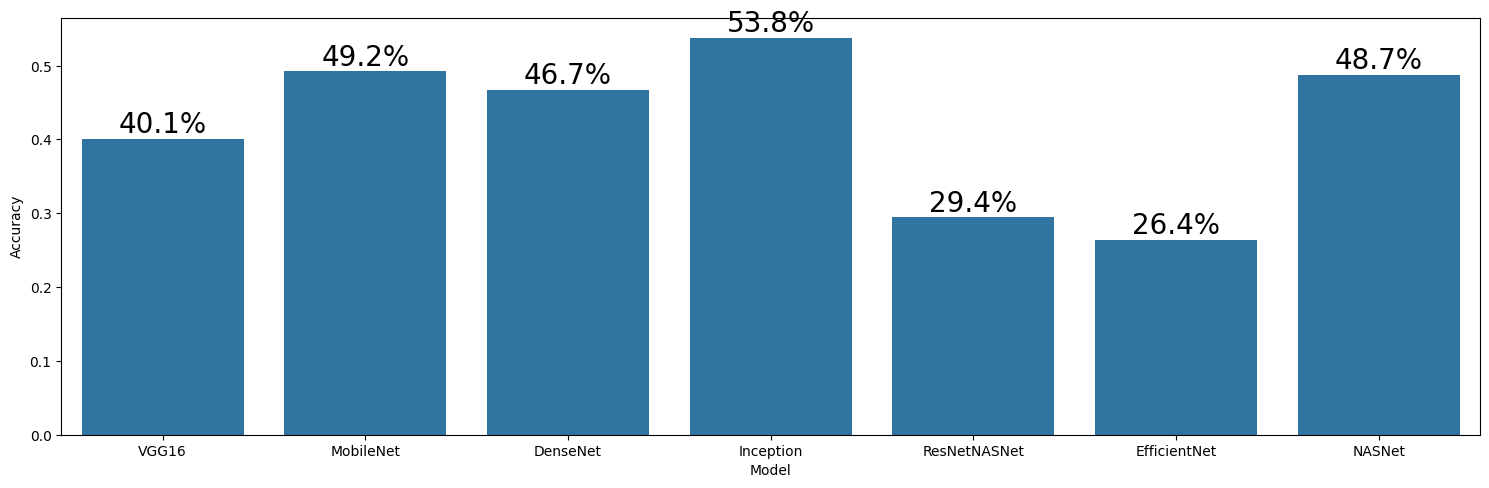

In [21]:
plt.figure(figsize=[15, 5])


sns.barplot(x='Model', y='Accuracy', data=df)


ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=20)


plt.tight_layout()

plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step


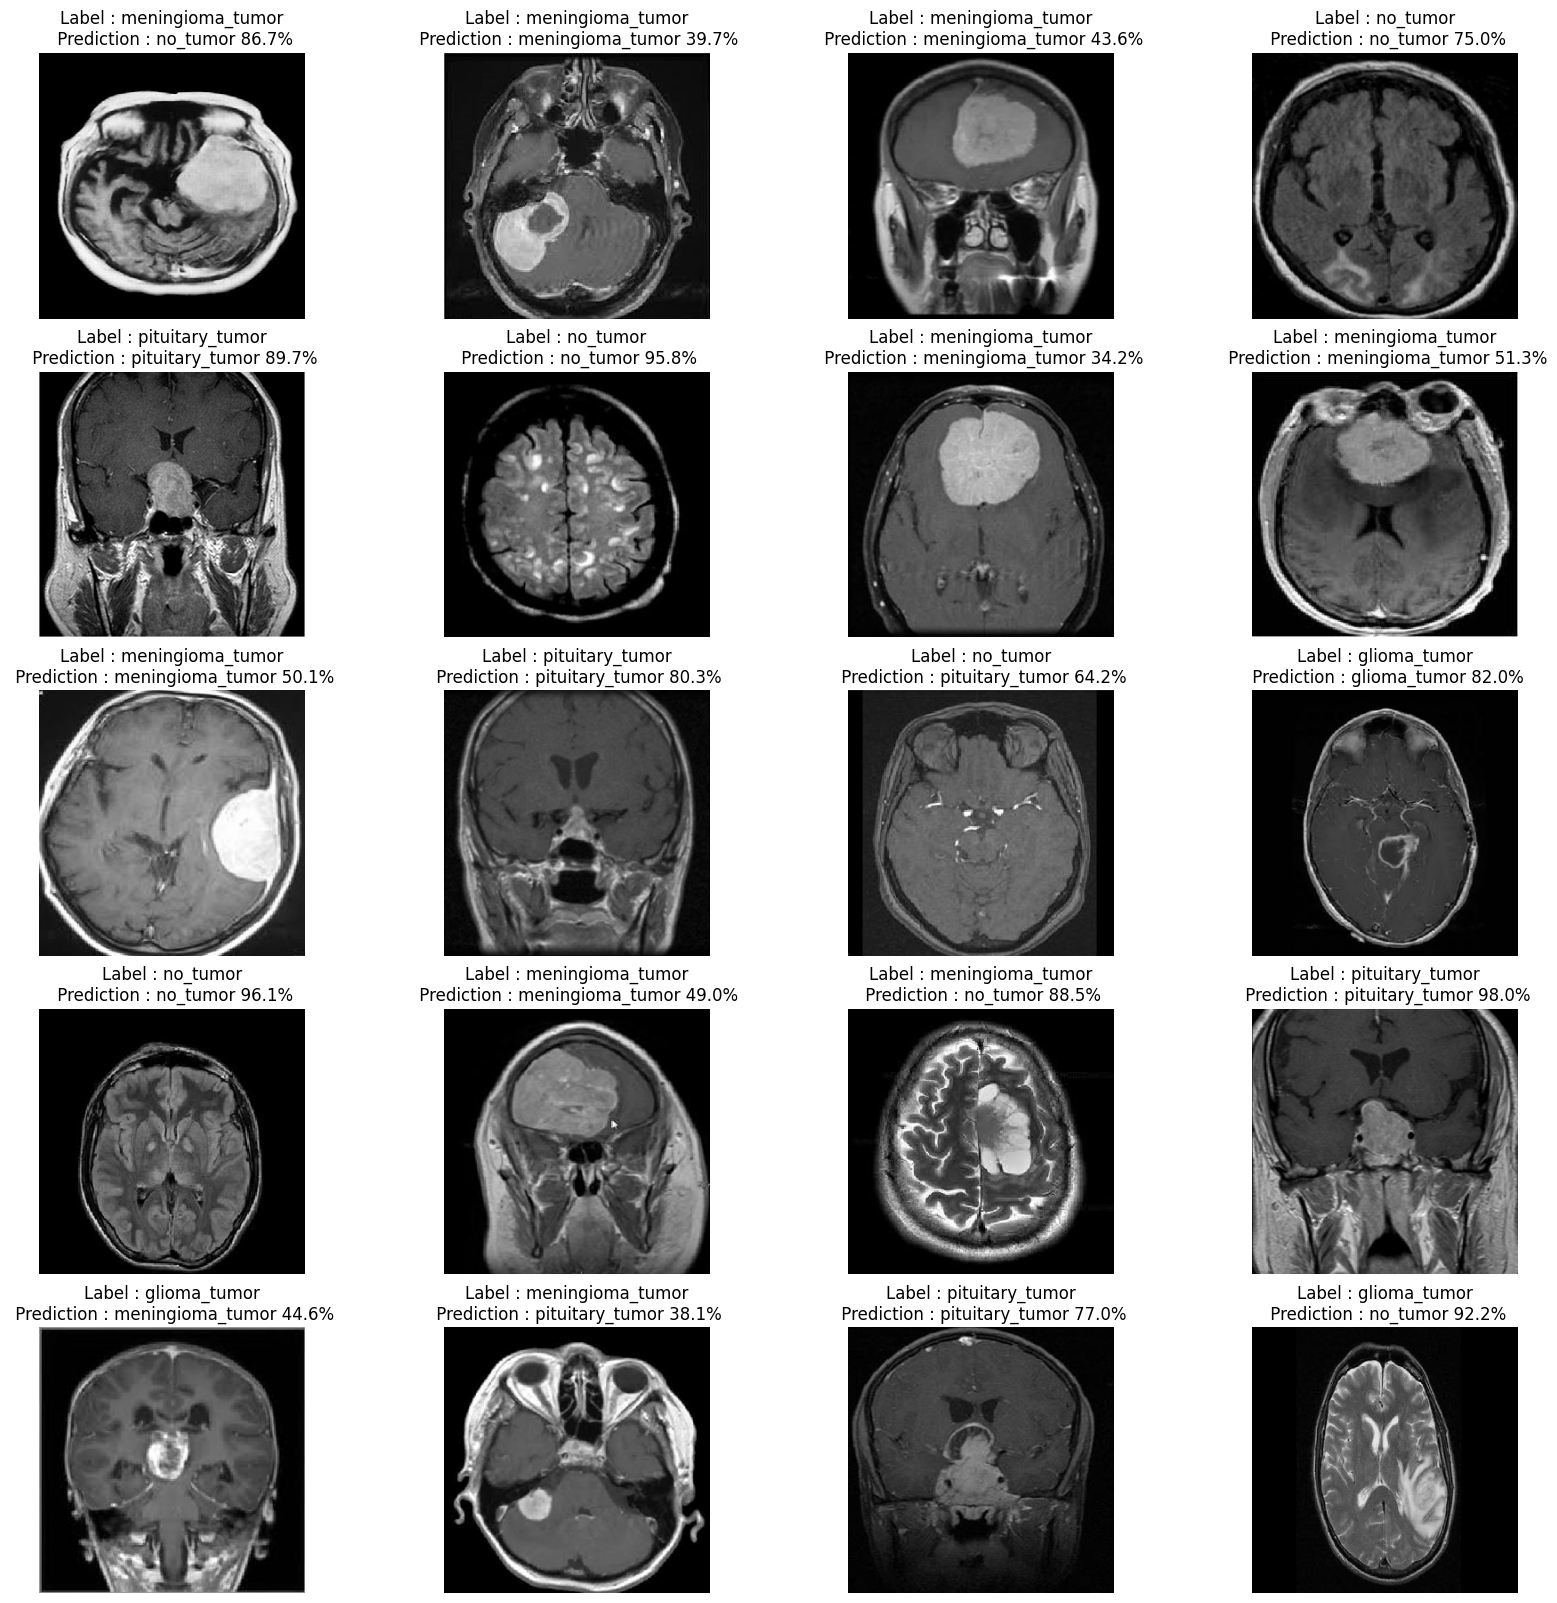

In [22]:
test_generator.reset()
img, label = next(test_generator)

prediction = model_Inception.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[20, 20])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()